### Accident Severity Prediction Model

##### This is a data science project to predict whether you will get into an accident and it's severity based on multiple attributes.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [3]:
df = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv', delimiter = ',',index_col = None)

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

In [6]:
#Dropping columns with a large set os missing values that cannot be filled
df.drop(columns={'INTKEY','EXCEPTRSNCODE','EXCEPTRSNDESC','SEGLANEKEY','CROSSWALKKEY'},axis=1,inplace=True)

#Drop all columns which are causal rather than correlated i.e. all columns tht indicate post accident information
df.drop(columns = {'COLLISIONTYPE','SDOT_COLCODE','SDOT_COLDESC','INATTENTIONIND','UNDERINFL','PEDROWNOTGRNT','ST_COLCODE','ST_COLDESC','HITPARKEDCAR','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT'}, axis=1,inplace=True)

#drop X,Y and LOCATION to make the model generalized and not just focussed on Seattle locations
df.drop(columns= {'X','Y','LOCATION'}, axis=1, inplace=True)

#Drop duplicate columns
df.drop(columns= {'SEVERITYCODE.1','SEVERITYDESC'}, axis=1, inplace=True)
df.head()

#Drop columns with no description in metadata and are unbalanced
df.drop(columns={'STATUS'},axis=1,inplace=True)

#Drop Unique ID columns that don't contribute to predition
df.drop(columns = {'OBJECTID','INCKEY','COLDETKEY','SDOTCOLNUM','REPORTNO','INCDATE'},axis=1, inplace=True)




In [7]:
df.head()

,SEVERITYCODE,ADDRTYPE,INCDTTM,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,2,Intersection,3/27/2013 2:54:00 PM,At Intersection (intersection related),Overcast,Wet,Daylight,NaN
1,1,Block,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,NaN
2,1,Block,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),Overcast,Dry,Daylight,NaN
3,1,Block,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),Clear,Dry,Daylight,NaN
4,2,Intersection,1/28/2004 8:04:00 AM,At Intersection (intersection related),Raining,Wet,Daylight,NaN


In [8]:
#RReplace NaN with N where column values are either 'Y' or blank
df['SPEEDING'].fillna('N',axis=0,inplace=True)
print(df['SPEEDING'].value_counts())

N    185340
Y      9333
Name: SPEEDING, dtype: int64


In [9]:
#Replace rows with NaN address types with highest frequency value
#df['ADDRTYPE'] = df['ADDRTYPE'].astype(str)
values = {'ADDRTYPE':'Block'}
df.fillna(value=values,axis=0,inplace=True)
#df.info()
df['ADDRTYPE'].value_counts()

Block           128852
Intersection     65070
Alley              751
Name: ADDRTYPE, dtype: int64

In [10]:
#Drop rows with NaN junction types since no value has extremely large frequency
#df['JUNCTIONTYPE'] = df['JUNCTIONTYPE'].astype(str)
df.dropna(subset=['JUNCTIONTYPE'],axis=0,inplace=True)
df = df[~df.JUNCTIONTYPE.str.contains("Unknown")]
#df.info()
df['JUNCTIONTYPE'].value_counts()



Mid-Block (not related to intersection)              89800
At Intersection (intersection related)               62810
Mid-Block (but intersection related)                 22790
Driveway Junction                                    10671
At Intersection (but not related to intersection)     2098
Ramp Junction                                          166
Name: JUNCTIONTYPE, dtype: int64

In [11]:
#Replace rows with NaN weather with highest frequency value

values = {'WEATHER':'Clear'}
df.fillna(value=values,axis=0,inplace=True)
#df.info()
df['WEATHER'].value_counts()

Clear                       114198
Raining                      32706
Overcast                     27237
Unknown                      11802
Snowing                        888
Other                          754
Fog/Smog/Smoke                 558
Sleet/Hail/Freezing Rain       112
Blowing Sand/Dirt               50
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64

In [12]:
#Replace rows with NaN weather with highest frequency value

values = {'ROADCOND':'Dry'}
df.fillna(value=values,axis=0,inplace=True)
#df.info()
df['ROADCOND'].value_counts()

Dry               127311
Wet                46811
Unknown            11687
Ice                 1182
Snow/Slush           984
Other                123
Standing Water       109
Sand/Mud/Dirt         68
Oil                   60
Name: ROADCOND, dtype: int64

In [13]:
#Drop rows with NaN weather with highest frequency value

values = {'LIGHTCOND':'Daylight'}
df.fillna(value=values,axis=0,inplace=True)
#df.info()
df['LIGHTCOND'].value_counts()

Daylight                    119018
Dark - Street Lights On      47656
Unknown                      10565
Dusk                          5793
Dawn                          2453
Dark - No Street Lights       1464
Dark - Street Lights Off      1164
Other                          211
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [14]:
df.head()

,SEVERITYCODE,ADDRTYPE,INCDTTM,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING
0,2,Intersection,3/27/2013 2:54:00 PM,At Intersection (intersection related),Overcast,Wet,Daylight,N
1,1,Block,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,N
2,1,Block,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),Overcast,Dry,Daylight,N
3,1,Block,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),Clear,Dry,Daylight,N
4,2,Intersection,1/28/2004 8:04:00 AM,At Intersection (intersection related),Raining,Wet,Daylight,N


In [15]:
df['INCDTTM']= pd.to_datetime(df['INCDTTM']) 
df['DAYOFWEEK'] = df['INCDTTM'].dt.dayofweek
df['MONTH'] = df['INCDTTM'].dt.month
df['HOUR'] = df['INCDTTM'].dt.hour
df.head()

,SEVERITYCODE,ADDRTYPE,INCDTTM,JUNCTIONTYPE,WEATHER,ROADCOND,LIGHTCOND,SPEEDING,DAYOFWEEK,MONTH,HOUR
0,2,Intersection,2013-03-27 14:54:00,At Intersection (intersection related),Overcast,Wet,Daylight,N,2,3,14
1,1,Block,2006-12-20 18:55:00,Mid-Block (not related to intersection),Raining,Wet,Dark - Street Lights On,N,2,12,18
2,1,Block,2004-11-18 10:20:00,Mid-Block (not related to intersection),Overcast,Dry,Daylight,N,3,11,10
3,1,Block,2013-03-29 09:26:00,Mid-Block (not related to intersection),Clear,Dry,Daylight,N,4,3,9
4,2,Intersection,2004-01-28 08:04:00,At Intersection (intersection related),Raining,Wet,Daylight,N,2,1,8


In [16]:
df['SEVERITYCODE'].value_counts()

1    130549
2     57786
Name: SEVERITYCODE, dtype: int64

In [17]:
#Data Balancing as sev 2 are less than 30% of the data outcomes
from sklearn.utils import resample


# Separate majority and minority classes
df_majority = df[df.SEVERITYCODE==1]
df_minority = df[df.SEVERITYCODE==2]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                              replace=True,     # sample with replacement
                              n_samples=130549,    # to match majority class
                              random_state=12345) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['SEVERITYCODE'].value_counts()

2    130549
1    130549
Name: SEVERITYCODE, dtype: int64

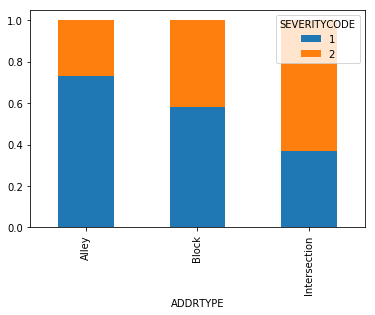

In [18]:
#Since most accidents seem to happen at 0 hour i.e. midnight 

df_plot = df_upsampled.groupby(['ADDRTYPE', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='ADDRTYPE', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='bar',stacked=True)

#More probability od sev2 with Intersection

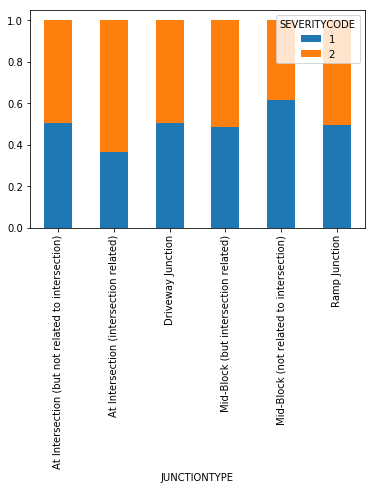

In [19]:
df_plot = df_upsampled.groupby(['JUNCTIONTYPE', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='JUNCTIONTYPE', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='bar',stacked=True)



#No significant relationship between JUNCTIONTYPE and SEVERITY

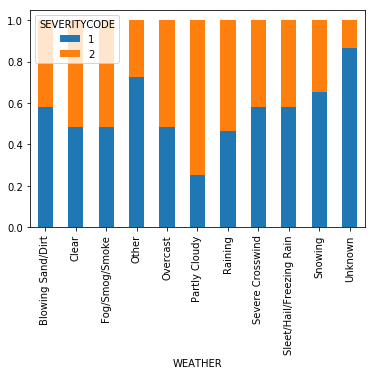

In [20]:
df_plot = df_upsampled.groupby(['WEATHER', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='WEATHER', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='bar',stacked=True)

#Highest Sev2 with Partly Cloudy weather

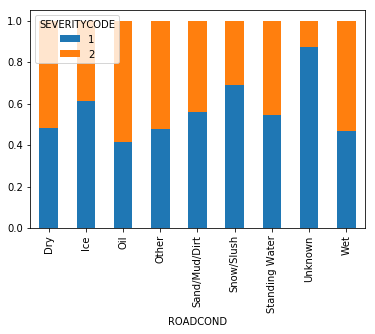

In [21]:
df_plot = df_upsampled.groupby(['ROADCOND', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='ROADCOND', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='bar',stacked=True)

#No significant relationship between ROAD CONDITION and SEVERITY CODE

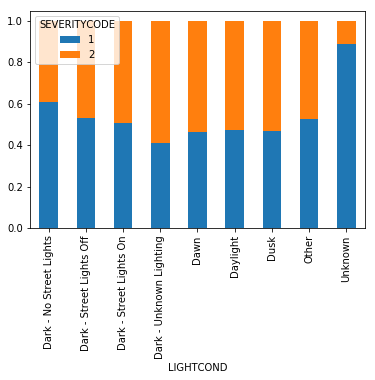

In [22]:
df_plot = df_upsampled.groupby(['LIGHTCOND', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='LIGHTCOND', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='bar',stacked=True)

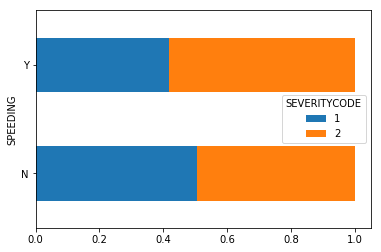

In [23]:
df_plot = df_upsampled.groupby(['SPEEDING', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='SPEEDING', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='barh',stacked=True)

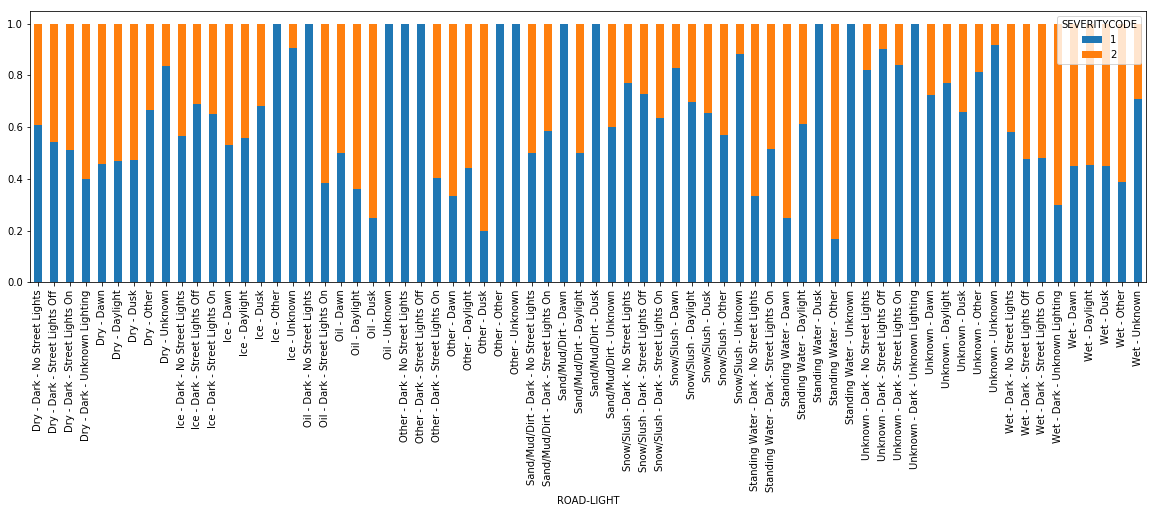

In [24]:
df_upsampled['ROAD-LIGHT'] = df["ROADCOND"].astype(str) + ' - ' + df["LIGHTCOND"].astype(str)
df_plot = df_upsampled.groupby(['ROAD-LIGHT', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='ROAD-LIGHT', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='bar',stacked=True,figsize=(20,5))

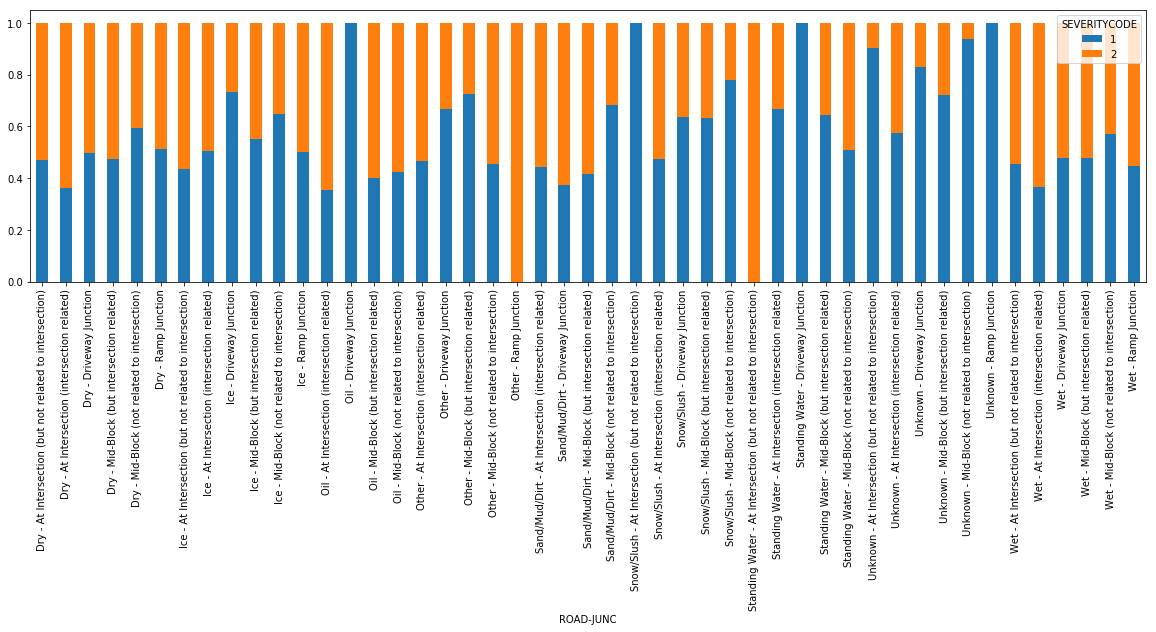

In [25]:
df_upsampled['ROAD-JUNC'] = df["ROADCOND"].astype(str) + ' - ' + df["JUNCTIONTYPE"].astype(str)
df_plot = df_upsampled.groupby(['ROAD-JUNC', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='ROAD-JUNC', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='bar',stacked=True,figsize=(20,5))

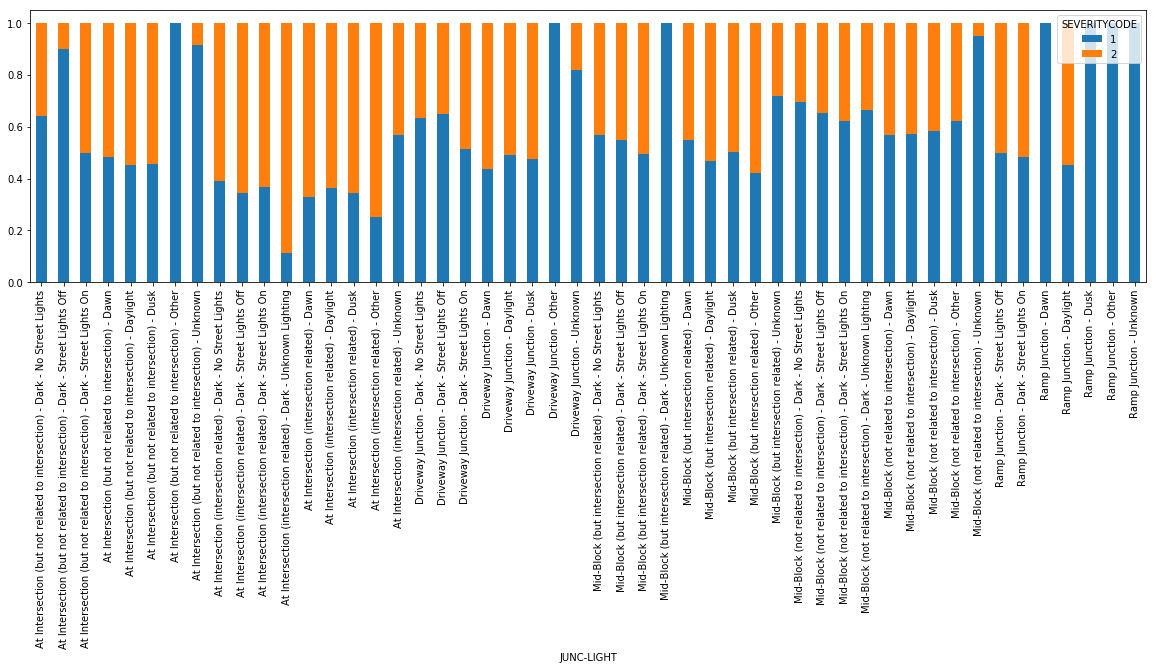

In [26]:
df_upsampled['JUNC-LIGHT'] = df["JUNCTIONTYPE"].astype(str) + ' - ' + df["LIGHTCOND"].astype(str)
df_plot = df_upsampled.groupby(['JUNC-LIGHT', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='JUNC-LIGHT', values=0).transpose().apply(lambda x: x / x.sum())
df_plot.transpose().plot(kind='bar',stacked=True,figsize=(20,5))

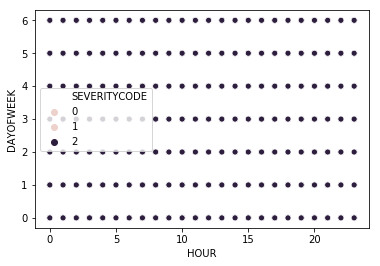

In [27]:
sns.scatterplot(data=df_upsampled, x="HOUR", y="DAYOFWEEK", hue="SEVERITYCODE")


KeyboardInterrupt: 

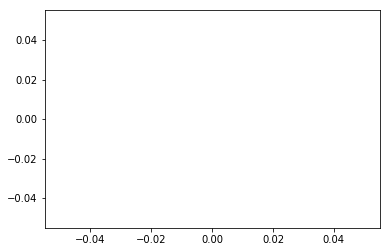

In [28]:
sns.scatterplot(data=df_upsampled, x="MONTH", y="DAYOFWEEK", hue="SEVERITYCODE")

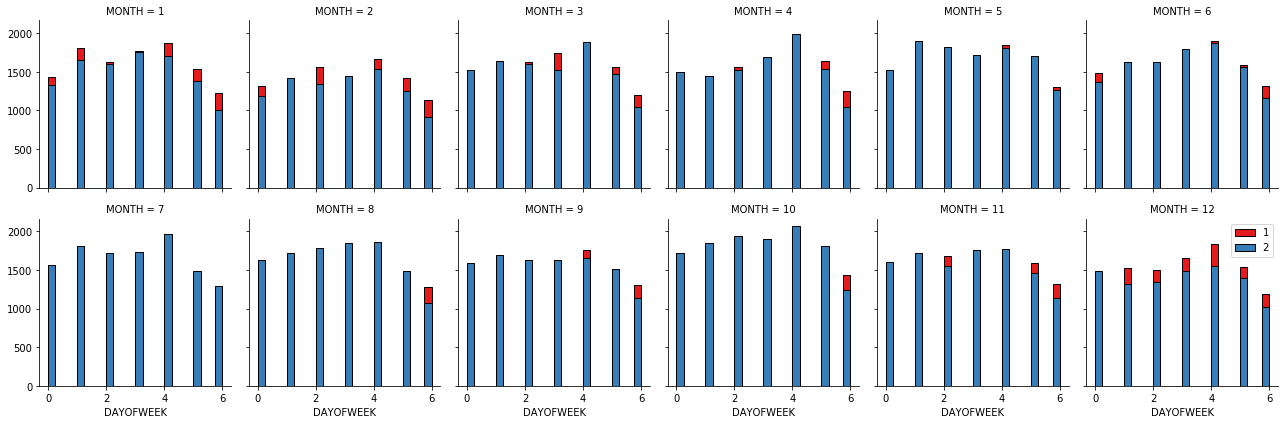

In [29]:
bins = 24
g = sns.FacetGrid(df_upsampled, col="MONTH", hue="SEVERITYCODE", palette="Set1", col_wrap=6)
g.map(plt.hist, 'DAYOFWEEK', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

###Majority SEV-1 in winter months and Sunday being most Sev2

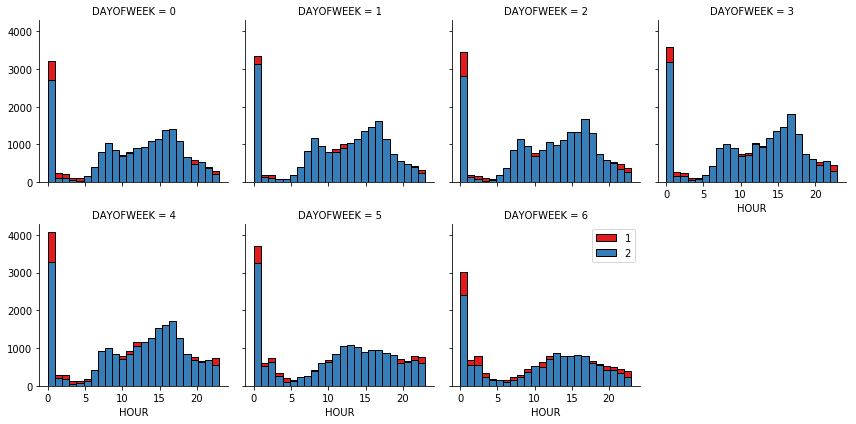

In [31]:
bins = 24
g = sns.FacetGrid(df_upsampled, col="DAYOFWEEK", hue="SEVERITYCODE", palette="Set1", col_wrap=4)
g.map(plt.hist, 'HOUR', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

###Majority SEV-1 in midnight

In [ ]:

df_plot = df_upsampled.groupby(['HOUR', 'SEVERITYCODE']).size().reset_index().pivot(columns='SEVERITYCODE', index='HOUR', values=0).transpose()
df_plot.transpose().plot(kind='bar',stacked=True,figsize=(20,5))

In [ ]:
df_upsampled.drop(columns={'ROAD-LIGHT','JUNC-LIGHT','ROAD-JUNC'},axis=0,inplace=True)

In [ ]:
#Create dummy variables for all ccategorical olumns

df_upsampled = pd.concat([df_upsampled,pd.get_dummies(df_upsampled['ADDRTYPE'])], axis=1)
df_upsampled = pd.concat([df_upsampled,pd.get_dummies(df_upsampled['JUNCTIONTYPE'])], axis=1)
df_upsampled = pd.concat([df_upsampled,pd.get_dummies(df_upsampled['WEATHER'])], axis=1)
df_upsampled = pd.concat([df_upsampled,pd.get_dummies(df_upsampled['ROADCOND'])], axis=1)
df_upsampled = pd.concat([df_upsampled,pd.get_dummies(df_upsampled['LIGHTCOND'])], axis=1)
df_upsampled.drop(columns = {'Block','Unknown'}, axis=1, inplace=True)

In [ ]:
df_upsampled.replace({'SPEEDING': {'N':0,'Y':1}}, inplace=True)

In [ ]:
df_upsampled['NIGHT'] = df_upsampled['HOUR'].apply(lambda x: 1 if (x in [1,2,3,20,21,22,23])  else 0)
df_upsampled['WINTER'] = df_upsampled['MONTH'].apply(lambda x: 1 if (x in [12,1,2])  else 0)

In [ ]:
#df_upsampled.drop(columns = {'HOUR'}, axis=1, inplace=True)
df_upsampled.drop(columns = {'INCDTTM','WEATHER','ROADCOND','LIGHTCOND','ADDRTYPE','JUNCTIONTYPE','DAYOFWEEK','MONTH','HOUR'}, axis=1, inplace=True)
df_upsampled.info()

In [ ]:
Features = df_upsampled
y = df_upsampled['SEVERITYCODE'].values
Features.drop(columns={'SEVERITYCODE'},axis=1,inplace=True)
X = Features
X.head()

In [ ]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 10
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = 10).fit(X_train,y_train)
yhat_knn=neigh.predict(X_test)
acc_knn = metrics.accuracy_score(y_test, yhat_knn)
f1_knn = f1_score(y_test, yhat_knn, average='weighted')
js_knn = jaccard_similarity_score(y_test, yhat_knn)


    
    
#mean_acc

In [ ]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

acc_knn
f1_knn = f1_score(y_test, yhat_knn, average='weighted')
js_knn = jaccard_similarity_score(y_test, yhat_knn)
print(acc_knn)
print(f1_knn)
print(js_knn)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
Ks = 19

    
#Train Model and Predict  
sevTree_test = DecisionTreeClassifier(criterion="entropy", max_depth = 19)
sevTree_test.fit(X_train,y_train)
yhat_dt=sevTree_test.predict(X_test)
acc_dt = metrics.accuracy_score(y_test, yhat_dt)
f1_dt = f1_score(y_test, yhat_dt, average='weighted')
js_dt = jaccard_similarity_score(y_test, yhat_dt)

print(acc_dt)
print(f1_dt)
print(js_dt)

    
    
#mean_acc

#depth 19

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
Ks = 19

    
#Train Model and Predict  
rf_test = RandomForestClassifier(criterion="entropy", max_depth = 19)
rf_test.fit(X_train,y_train)
yhat_rf=rf_test.predict(X_test)
acc_rf = metrics.accuracy_score(y_test, yhat_rf)
f1_rf = f1_score(y_test, yhat_rf, average='weighted')
js_rf = jaccard_similarity_score(y_test, yhat_rf)

print(acc_rf)
print(f1_rf)
print(js_rf)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat_knn)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_knn))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')



In [ ]:
cnf_matrix = confusion_matrix(y_test, yhat_dt)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_dt))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')


In [ ]:
cnf_matrix = confusion_matrix(y_test, yhat_rf)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat_rf))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity 1','Severity 2'],normalize= False,  title='Confusion matrix')
